In [5]:
import pandas as pd
import numpy as np
from datetime import datetime
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

## The currency dataset

In [6]:
# source files
jpy_files = ['JPYUSD100_2016_5min_b0.csv','JPYUSD100_2017_5min_b0.csv','JPYUSD100_2018_5min_b0.csv','JPYUSD100_2019_5min_b0.csv']
eur_files = ['EURUSD_2016_5min_b0.csv','EURUSD_2017_5min_b0.csv','EURUSD_2018_5min_b0.csv','EURUSD_2019_5min_b0.csv']
gbp_files = ['GBPUSD_2016_5min_b0.csv','GBPUSD_2017_5min_b0.csv','GBPUSD_2018_5min_b0.csv','GBPUSD_2019_5min_b0.csv']

In [3]:
# reduce memory usage by converting to proper data types
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else: df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

In [7]:
def concat_curr_files(c_files):
    '''
    Concatenates the dataframes of the same currency
    '''
    usecols=['ctime','mean','std','bar_len','bar_spearman','bar_log_r','first_r','max_r','min_r','last_r','bar_quantile_25_r','bar_quantile_75_r']
    df_full = df = pd.DataFrame(columns = usecols)
    for data_file in c_files:
        df = pd.read_csv(f'fx_data/{data_file}', usecols=usecols)
        df_full = pd.concat([df_full, df])

    # time column to index
    df_full['ctime']  = pd.to_datetime(df_full['ctime'])
    df_full = df_full.set_index('ctime')

    # drop bars without tick
    df_full = df_full.loc[df_full['bar_len']>0]

    return df_full

In [8]:
# fx dataframes
df_jpy = concat_curr_files(jpy_files)
df_eur = concat_curr_files(eur_files)
df_gbp = concat_curr_files(gbp_files)

In [9]:
#df_jpy = reduce_mem_usage(df_jpy)
#df_eur = reduce_mem_usage(df_eur)
#df_gbp = reduce_mem_usage(df_gbp)

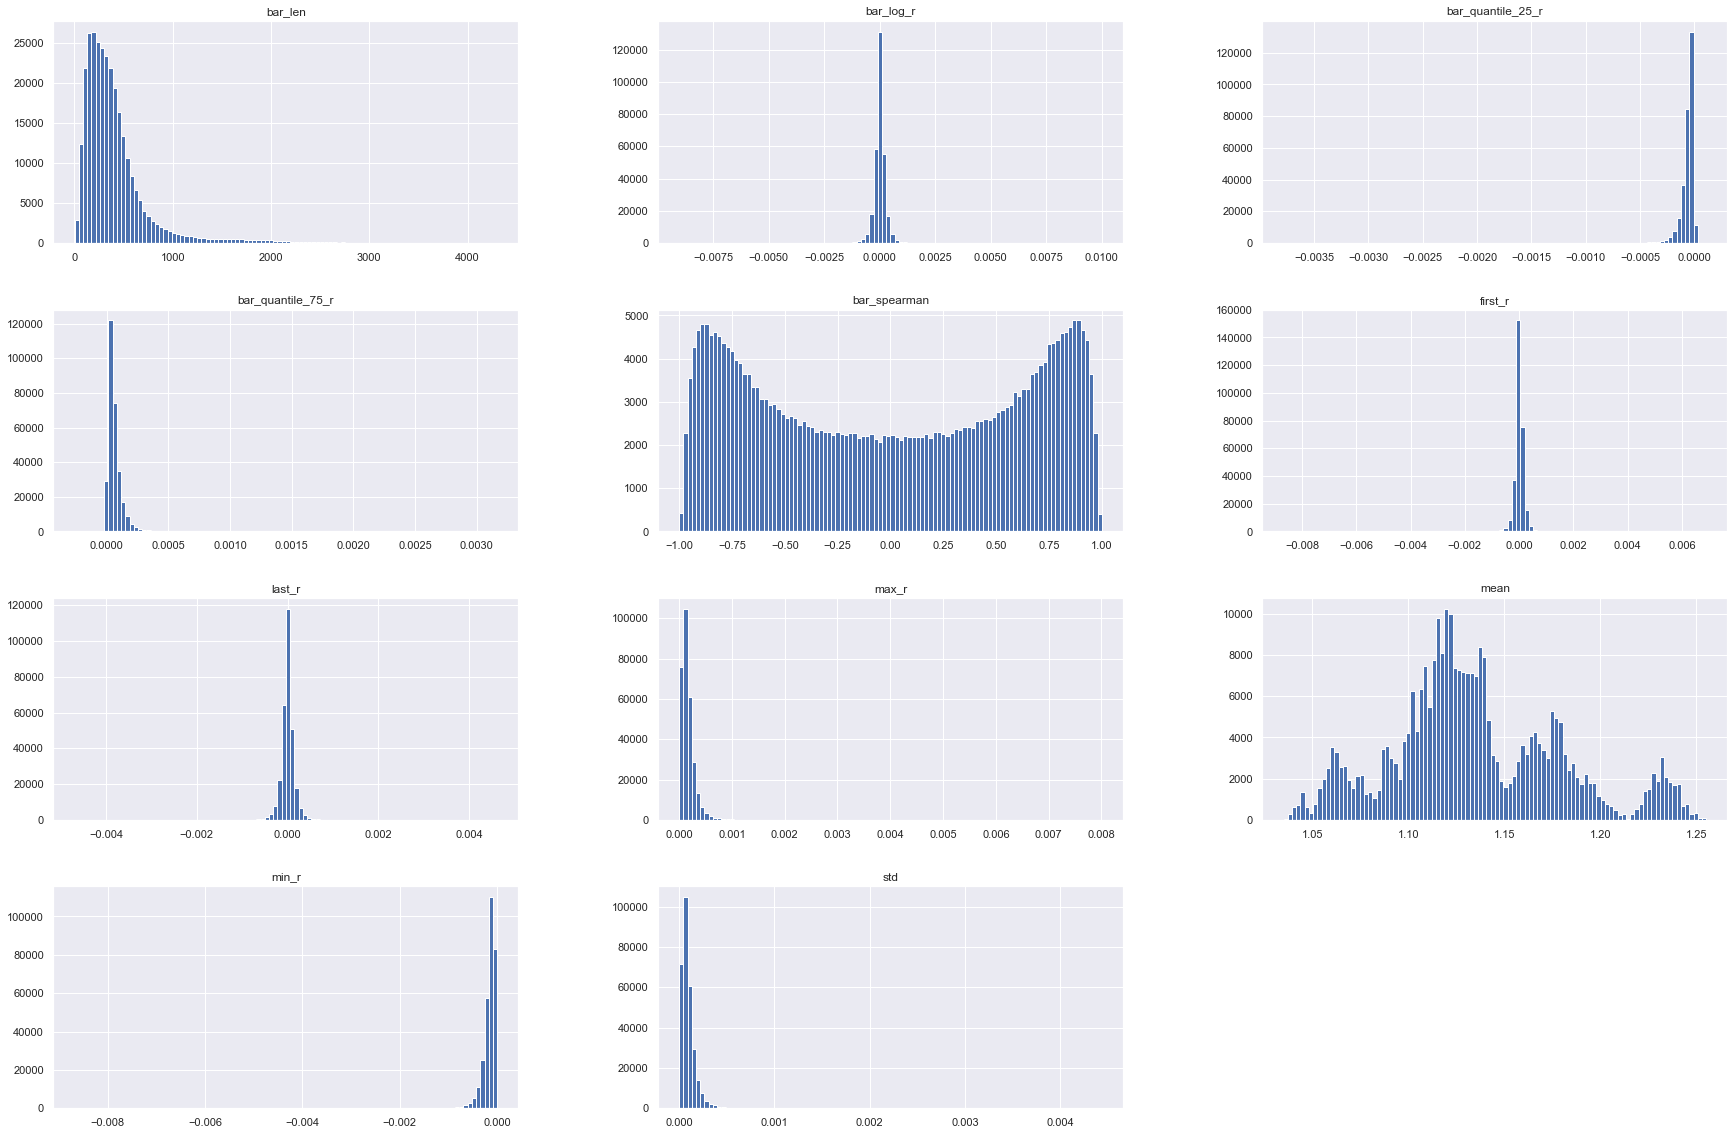

In [10]:
df_eur.hist(figsize=(30, 20), bins=100);

In [11]:
# set hierarchical index
df_eur.columns = pd.MultiIndex.from_product([['c_eur'], df_eur.columns])
df_gbp.columns = pd.MultiIndex.from_product([['c_gbp'], df_gbp.columns])
df_jpy.columns = pd.MultiIndex.from_product([['c_jpy'], df_jpy.columns])

In [12]:
# make the currency dataframe
df_curr = pd.concat([df_eur, df_gbp, df_jpy], axis=1, join='inner')

In [13]:
# time features
df_curr['month'] = df_curr.index.month
df_curr['dow'] = df_curr.index.dayofweek
df_curr['hour'] = df_curr.index.hour

In [14]:
df_curr.columns

MultiIndex([('c_eur',              'mean'),
            ('c_eur',               'std'),
            ('c_eur',           'bar_len'),
            ('c_eur',      'bar_spearman'),
            ('c_eur',         'bar_log_r'),
            ('c_eur',           'first_r'),
            ('c_eur',             'max_r'),
            ('c_eur',             'min_r'),
            ('c_eur',            'last_r'),
            ('c_eur', 'bar_quantile_25_r'),
            ('c_eur', 'bar_quantile_75_r'),
            ('c_gbp',              'mean'),
            ('c_gbp',               'std'),
            ('c_gbp',           'bar_len'),
            ('c_gbp',      'bar_spearman'),
            ('c_gbp',         'bar_log_r'),
            ('c_gbp',           'first_r'),
            ('c_gbp',             'max_r'),
            ('c_gbp',             'min_r'),
            ('c_gbp',            'last_r'),
            ('c_gbp', 'bar_quantile_25_r'),
            ('c_gbp', 'bar_quantile_75_r'),
            ('c_jpy',           

In [15]:
def add_onehotencode_columns(df, source_names, top_names=None):
    '''
    On hot encode categorical columns
    Parameters:
        df (Dataframe): the dataframe of the original features
        source_names (list): list of columns to oh_encode
        top_names: names of top hierarchy
    Returns:
        df: dataframe with ohe columns
    '''
    if top_names == None: top_names=source_names
    info = zip(source_names, top_names)
    for source, top in info:
        df_aux = pd.get_dummies(df[source],prefix='', drop_first=False)
        df_aux.columns = pd.MultiIndex.from_product([[top], df_aux.columns])
        df = pd.concat([df, df_aux], axis=1, join='inner')
    return df

In [16]:
df_curr = add_onehotencode_columns(df_curr, ['month', 'dow', 'hour'])

In [17]:
# drop not encoded columns
df_curr = df_curr.drop(columns=[('month',''), ('dow',''), ('hour','')])

In [18]:
df_curr.columns

MultiIndex([('c_eur',              'mean'),
            ('c_eur',               'std'),
            ('c_eur',           'bar_len'),
            ('c_eur',      'bar_spearman'),
            ('c_eur',         'bar_log_r'),
            ('c_eur',           'first_r'),
            ('c_eur',             'max_r'),
            ('c_eur',             'min_r'),
            ('c_eur',            'last_r'),
            ('c_eur', 'bar_quantile_25_r'),
            ('c_eur', 'bar_quantile_75_r'),
            ('c_gbp',              'mean'),
            ('c_gbp',               'std'),
            ('c_gbp',           'bar_len'),
            ('c_gbp',      'bar_spearman'),
            ('c_gbp',         'bar_log_r'),
            ('c_gbp',           'first_r'),
            ('c_gbp',             'max_r'),
            ('c_gbp',             'min_r'),
            ('c_gbp',            'last_r'),
            ('c_gbp', 'bar_quantile_25_r'),
            ('c_gbp', 'bar_quantile_75_r'),
            ('c_jpy',           

## The News dataset

In [19]:
df_news = pd.read_csv('news_data/news_data_tight.csv')
#df_news = reduce_mem_usage(df_news)

In [20]:
# time column to index
df_news['ctime']  = pd.to_datetime(df_news['Date'])
df_news = df_news.set_index('ctime')
df_news = df_news.drop(columns=['Date'])

In [21]:
df_news.columns

Index(['Event', 'Previous', 'Consensus', 'Actual', 'Currency', 'change',
       'surp'],
      dtype='object')

In [22]:
# keep our final news features
# will drop Previous later
df_news = df_news[['Event', 'Currency', 'Actual', 'Previous', 'change', 'surp']]

In [23]:
# check for nans
df_news.isnull().any()

Event       False
Currency    False
Actual      False
Previous    False
change      False
surp        False
dtype: bool

In [24]:
event_types = list(df_news['Event'].unique())
print(event_types)
print('Number of event types: ', len(event_types))

['france markit manufacturing pmi', 'germany markit manufacturing pmi', 'united states ism prices paid', 'united states ism manufacturing pmi', 'germany unemployment change', 'european monetary union consumer price index  core yoy', 'european monetary union consumer price index yoy', 'united states adp employment change', 'united states trade balance', 'united states ism nonmanufacturing pmi', 'usd event', 'united states initial jobless claims', 'united states unemployment rate', 'united states nonfarm payrolls', 'japan current account nsa', 'jpy speech', 'gbp speech', 'united states jolts job openings', 'eur event', 'united kingdom boe mpc vote hike', 'united kingdom boe mpc vote unchanged', 'united kingdom boe mpc vote cut', 'united kingdom boe asset purchase facility', 'united kingdom boe interest rate decision', 'gbp event', 'united states retail sales ex autos mom', 'united states retail sales mom', 'united states reutersmichigan consumer sentiment index', 'united states building 

In [25]:
# standardize previous consensus and actual for every event type separately
# df[['Previous','Consensus','Actual']].loc[df['Event']=='united states retail sales mom'].apply(lambda x: (x - x.min()) / (x.max() - x.min()))

In [26]:
# two possible ways to go with news data
# 1: standardize Actual/change/surp for every event type separately, and onehotencode the events -> less features
# 2: onehotencode Actual/change/surp based on Event, then onehotencode event -> more features, but we will condense this by embedding layers
# we will go with 2.

In [27]:
df_news

,Event,Currency,Actual,Previous,change,surp
ctime,,,,,,
2016-01-04 08:50:00,france markit manufacturing pmi,EUR,51.40,51.60,-0.20,-0.20
2016-01-04 08:55:00,germany markit manufacturing pmi,EUR,53.20,53.00,0.20,0.20
2016-01-04 15:00:00,united states ism prices paid,USD,33.50,35.50,-2.00,-1.70
2016-01-04 15:00:00,united states ism manufacturing pmi,USD,48.20,48.60,-0.40,-0.80
2016-01-05 08:55:00,germany unemployment change,EUR,14.00,14.00,0.00,0.00
...,...,...,...,...,...,...
2019-12-26 13:30:00,united states initial jobless claims,USD,222.00,235.00,-13.00,-2.00
2019-12-26 13:30:00,united states initial jobless claims 4week ave...,USD,228.00,225.75,2.25,2.25
2019-12-26 23:30:00,japan tokyo cpi ex fresh food yoy,JPY,0.80,0.60,0.20,0.20


In [28]:
# under 'raw' are the original not separated (one hot encoded) features
df_news.columns = pd.MultiIndex.from_product([['raw'], df_news.columns])

In [29]:
# generate onehotencoded events for the events and the features
df_news = add_onehotencode_columns(df_news, [('raw','Currency'), ('raw','Event')], ['event_cur', 'event_exist'])

In [30]:
# we make top hierarchies for our main features from 'event_exist'
# add the onehotencoded features with NaN
# we need NaNs for a while, because 0.0 can be a valid number
ohe_tops = ['actual_ohe', 'previous_ohe', 'surprise_ohe', 'change_ohe', 'after_counter_ohe']
for ohe in ohe_tops:
    df_aux = df_news['event_exist'].replace(0, np.nan)
    df_aux.columns = pd.MultiIndex.from_product([[ohe], df_aux.columns])
    df_news = pd.concat([df_news, df_aux], axis=1, sort=False)

In [31]:
len(list(df_news.columns))

466

In [32]:
# update the onehotencoded value features
df_news['actual_ohe'] = df_news['actual_ohe'].mul(df_news['raw', 'Actual'],axis=0)
df_news['previous_ohe'] = df_news['previous_ohe'].mul(df_news['raw', 'Previous'],axis=0)
df_news['change_ohe'] = df_news['change_ohe'].mul(df_news['raw', 'change'],axis=0)
df_news['surprise_ohe'] = df_news['surprise_ohe'].mul(df_news['raw', 'surp'],axis=0)

In [33]:
# we have datetimes with multiple events
df_news.index.value_counts()

2019-11-27 13:30:00    9
2017-11-02 12:00:00    8
2019-07-25 12:30:00    8
2017-09-14 11:00:00    7
2017-05-11 11:00:00    7
                      ..
2017-05-22 14:30:00    1
2019-05-22 08:30:00    1
2019-03-12 19:00:00    1
2018-04-11 11:00:00    1
2016-12-27 15:00:00    1
Name: ctime, Length: 2549, dtype: int64

In [34]:
# sum events of the same datetime, 
# onehotencoded columns are ok, as they don't have multiple occurence for the same datetiem (except _event and _speech, which we will clip), 
# raw columns will have some false sums, we will drop them
# without min_count=1 sum of NaNs would be zero, we don't want that, zero is a valid value, so sum of Nans shouldn't produce zero => min_count=1
df_news = df_news.groupby(df_news.index).sum(min_count=1)

In [35]:
# drop original columns
df_news = df_news.drop(columns=['raw'])

In [36]:
# in my experience the main event moves the price, so more events shouldn't get linear weights
print(df_news['event_cur']['_USD'].unique())
print(df_news['event_cur']['_EUR'].unique())
print(df_news['event_cur']['_GBP'].unique())
print(df_news['event_cur']['_JPY'].unique())

[0 2 1 3 4 5 6 7 9]
[1 0 2 3 4]
[0 1 6 5 2 7 8 3]
[0 1 2 3]


In [37]:
# get the square root of the currency events
df_news['event_cur'] = df_news['event_cur']**(1/2)
print(df_news['event_cur']['_USD'].unique())
print(df_news['event_cur']['_EUR'].unique())
print(df_news['event_cur']['_GBP'].unique())
print(df_news['event_cur']['_JPY'].unique())

[0.         1.41421356 1.         1.73205081 2.         2.23606798
 2.44948974 2.64575131 3.        ]
[1.         0.         1.41421356 1.73205081 2.        ]
[0.         1.         2.44948974 2.23606798 1.41421356 2.64575131
 2.82842712 1.73205081]
[0.         1.         1.41421356 1.73205081]


In [38]:
print(len(list(df_news.columns)))
list(df_news.columns)

460


tual_ohe', '_united states initial jobless claims 4week average'),
 ('actual_ohe', '_united states ism manufacturing pmi'),
 ('actual_ohe', '_united states ism nonmanufacturing pmi'),
 ('actual_ohe', '_united states ism prices paid'),
 ('actual_ohe', '_united states jolts job openings'),
 ('actual_ohe', '_united states michigan consumer sentiment index'),
 ('actual_ohe', '_united states new home sales mom'),
 ('actual_ohe', '_united states nondefense capital goods orders ex aircraft'),
 ('actual_ohe', '_united states nonfarm payrolls'),
 ('actual_ohe', '_united states retail sales control group'),
 ('actual_ohe', '_united states retail sales ex autos mom'),
 ('actual_ohe', '_united states retail sales mom'),
 ('actual_ohe', '_united states reutersmichigan consumer sentiment index'),
 ('actual_ohe', '_united states trade balance'),
 ('actual_ohe', '_united states unemployment rate'),
 ('actual_ohe', '_usd event'),
 ('actual_ohe', '_usd speech'),
 ('previous_ohe', '_eur event'),
 ('previ

## The merged dataset

In [39]:
# build df with all data
df_full = pd.merge(df_curr, df_news, how='left', left_index=True, right_index=True)

In [40]:
# enable garbage collection of old df-s
'''
del df_curr
del df_news
'''
del df_gbp
del df_eur
del df_jpy
del df_aux

In [41]:
df_full

c_eur                                           \
                         mean       std bar_len bar_spearman bar_log_r   
ctime                                                                    
2016-01-03 22:00:00  1.087467  0.000015    28.0    -0.737459 -0.000037   
2016-01-03 22:05:00  1.087362  0.000049   155.0    -0.181051 -0.000230   
2016-01-03 22:10:00  1.086980  0.000105   138.0    -0.460522 -0.000248   
2016-01-03 22:15:00  1.086938  0.000043   125.0     0.282268 -0.000028   
2016-01-03 22:20:00  1.087057  0.000148   115.0    -0.043127 -0.000120   
...                       ...       ...     ...          ...       ...   
2019-12-31 21:35:00  1.121460  0.000037    62.0    -0.800736 -0.000080   
2019-12-31 21:40:00  1.121460  0.000028    41.0    -0.141550 -0.000009   
2019-12-31 21:45:00  1.121388  0.000046   108.0     0.612689 -0.000018   
2019-12-31 21:50:00  1.121327  0.000046    97.0    -0.912678 -0.000143   
2019-12-31 21:55:00  1.121247  0.000131    91.0     0.075062  0.000294   

                                                                               \
                      first_r     max_r     min_r    last_r bar_quantile_25_r   
ctime                                                                           
2016-01-03 22:00:00  0.000030  0.000030 -0.000016 -0.000007         -0.000009   
2016-01-03 22:05:00  0.000081  0.000081 -0.000149 -0.000149         -0.000029   
2016-01-03 22:10:00  0.000203  0.000203 -0.000147 -0.000046         -0.000064   
2016-01-03 22:15:00 -0.000007  0.000057 -0.000108 -0.000035         -0.000007   
2016-01-03 22:20:00 -0.000144  0.000224 -0.000264 -0.000264         -0.000126   
...                       ...       ...       ...       ...               ...   
2019-12-31 21:35:00  0.000062  0.000062 -0.000036 -0.000018         -0.000027   
2019-12-31 21:40:00 -0.000027  0.000035 -0.000054 -0.000036         -0.000018   
2019-12-31 21:45:00  0.000029  0.000047 -0.000096  0.000011         -0.000025   
2019-12-31 21:50:00  0.000056  0.000092 -0.000122 -0.000086         -0.000015   
2019-12-31 21:55:00 -0.000033  0.000261 -0.000123  0.000261         -0.000078   

                     ...  \
                     ...   
ctime                ...   
2016-01-03 22:00:00  ...   
2016-01-03 22:05:00  ...   
2016-01-03 22:10:00  ...   
2016-01-03 22:15:00  ...   
2016-01-03 22:20:00  ...   
...                  ...   
2019-12-31 21:35:00  ...   
2019-12-31 21:40:00  ...   
2019-12-31 21:45:00  ...   
2019-12-31 21:50:00  ...   
2019-12-31 21:55:00  ...   

                                                             after_counter_ohe  \
                    _united states nondefense capital goods orders ex aircraft   
ctime                                                                            
2016-01-03 22:00:00                                                NaN           
2016-01-03 22:05:00                                                NaN           
2016-01-03 22:10:00                                                NaN           
2016-01-03 22:15:00                                                NaN           
2016-01-03 22:20:00                                                NaN           
...                                                                ...           
2019-12-31 21:35:00                                                NaN           
2019-12-31 21:40:00                                                NaN           
2019-12-31 21:45:00                                                NaN           
2019-12-31 21:50:00                                                NaN           
2019-12-31 21:55:00                                                NaN           

                                                     \
                    _united states nonfarm payrolls   
ctime                                                 
2016-01-03 22:00:00                             NaN   
2016-01-03 22:05:00                             NaN   
2016-01-03 22:10:00                

In [42]:
# because speeches and events are groups of events, it is possible, that there are values more than 1 in after_counter_ohe and event_ohe
for col in df_full['after_counter_ohe'].columns:
    print(df_full['after_counter_ohe', col].unique())

[nan  1.  3.  2.]
[nan  1.  2.]
[nan  1.]
[nan  1.]
[nan  1.]
[nan  1.]
[nan  1.]
[nan  1.]
[nan  1.]
[nan  1.]
[nan  1.  2.  3.]
[nan  1.  2.]
[nan  1.]
[nan  1.]
[nan  1.]
[nan  1.]
[nan  1.]
[nan  1.]
[nan  1.]
[nan  1.]
[nan  1.]
[nan  1.]
[nan  1.]
[nan  1.  2.]
[nan  1.]
[nan  1.]
[nan  1.]
[nan  1.]
[nan  1.]
[nan  1.]
[nan  1.]
[nan  1.]
[nan  1.]
[nan  1.]
[nan  1.]
[nan  1.]
[nan  1.]
[nan  1.]
[nan  1.]
[nan  1.]
[nan  1.]
[nan  1.]
[nan  1.]
[nan  1.]
[nan  1.]
[nan  1.]
[nan  1.]
[nan  1.]
[nan  1.  2.]
[nan  1.]
[nan  1.]
[nan  1.]
[nan  1.]
[nan  1.]
[nan  1.]
[nan  1.  2.]
[nan  1.]
[nan  1.]
[nan  1.]
[nan  1.]
[nan  1.]
[nan  1.]
[nan  1.]
[nan  1.]
[nan  1.]
[nan  1.]
[nan  1.]
[nan  1.]
[nan  1.]
[nan  1.]
[nan  1.]
[nan  1.]
[nan  1.]
[nan  1.]
[nan  1.  2.  4.  3.]
[nan  1.  2.]


In [43]:
# test before
df_full['after_counter_ohe'].loc[:, ['_eur event']]['_eur event'].unique()

array([nan,  1.,  3.,  2.])

In [44]:
# lets clip 'after_counter_ohe' and 'existence_ohe' (multiple events of the same currency are represented in the 'event_cur'
df_full['after_counter_ohe'] = df_full['after_counter_ohe'].clip(0.0,1.0)
df_full['event_exist'] = df_full['event_exist'].clip(0.0,1.0)

In [45]:
# test after / ok
df_full['after_counter_ohe'].loc[:, ['_eur event']]['_eur event'].unique()

array([nan,  1.])

In [46]:
# with these methods we could continously input changing consensus data (what data I don't have)

# replace currency with 0 where NaN
df_full['event_cur'] = df_full['event_cur'].fillna(0)
# replace event exist with 0 where NaN
df_full['event_exist'] = df_full['event_exist'].fillna(0)

In [47]:
# replace NaN actuals with last known actual
df_full['actual_ohe'] = df_full['actual_ohe'].astype('float32').fillna(method='ffill')
# replace previous backward to fill the NaNs at the beginning of the actuals
df_full['previous_ohe'] = df_full['previous_ohe'].astype('float32').fillna(method='bfill')

In [48]:
# fill remaining actual NaNs
df_full['actual_ohe'] = df_full['actual_ohe'].fillna(df_full['previous_ohe'])

In [49]:
df_full['change_ohe'] = df_full['change_ohe'].fillna(df_full['actual_ohe'] - df_full['previous_ohe'])
df_full['change_ohe'] = df_full['change_ohe'].fillna(method='ffill')

In [50]:
df_full['surprise_ohe'] = df_full['surprise_ohe'].fillna(method='ffill')
df_full['surprise_ohe'] = df_full['surprise_ohe'].fillna(0)

In [51]:
df_full = df_full.drop(columns='previous_ohe')

In [52]:
df_full.index[0]

Timestamp('2016-01-03 22:00:00')

In [53]:
# set the first counters to zero
df_full.loc[df_full.index=='2016-01-03 22:00:00', 'after_counter_ohe'] = 0.0

In [54]:
df_full['after_counter_ohe'].head(2)

,_eur event,_eur speech,_european monetary union consumer price index core yoy,_european monetary union consumer price index yoy,_european monetary union ecb deposit rate decision,_european monetary union ecb interest rate decision,_european monetary union gross domestic product sa qoq,_european monetary union gross domestic product sa yoy,_european monetary union markit pmi composite,_france markit manufacturing pmi,...,_united states nondefense capital goods orders ex aircraft,_united states nonfarm payrolls,_united states retail sales control group,_united states retail sales ex autos mom,_united states retail sales mom,_united states reutersmichigan consumer sentiment index,_united states trade balance,_united states unemployment rate,_usd event,_usd speech
ctime,,,,,,,,,,,,,,,,,,,,,
2016-01-03 22:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-01-03 22:05:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [55]:
# after_counter_ohe will count back from the event time (which is 1.0 if event occured at the time)
# this can help the network to count for the later effect of the event
# we generate a kind of fading memory of 10*24*12 bars, which is about 10 workdays
# should have been shorter
memloss = -1/(10*24*12)
cols = list(df_full['after_counter_ohe'].columns)

In [56]:
# count the memory
for col in cols:
    nul = df_full['after_counter_ohe', col].isnull()
    df_full['after_counter_ohe', col] = nul.groupby((nul.diff() == 1).cumsum()).cumsum()*memloss + df_full['after_counter_ohe', col].ffill()    

In [57]:
# clip negative values (after 10*24*12 bars)
df_full['after_counter_ohe'] = df_full['after_counter_ohe'].clip(0.0,1.0)

In [58]:
top_level = list(df_full.columns.get_level_values(0).unique())
top_level

['c_eur',
 'c_gbp',
 'c_jpy',
 'month',
 'dow',
 'hour',
 'event_cur',
 'event_exist',
 'actual_ohe',
 'surprise_ohe',
 'change_ohe',
 'after_counter_ohe']

In [59]:
# we have some NaN, but few relative to the dataset
for top_h in top_level:
    print(top_h, '***********')
    print(df_full[top_h].isna().any().loc[df_full[top_h].isna().any()==True])
    print(df_full[top_h].isna().sum().loc[df_full[top_h].isna().sum()>0])

c_eur ***********
std             True
bar_spearman    True
dtype: bool
std              5
bar_spearman    44
dtype: int64
c_gbp ***********
std             True
bar_spearman    True
dtype: bool
std              8
bar_spearman    42
dtype: int64
c_jpy ***********
std             True
bar_spearman    True
dtype: bool
std             17
bar_spearman    74
dtype: int64
month ***********
Series([], dtype: bool)
Series([], dtype: int64)
dow ***********
Series([], dtype: bool)
Series([], dtype: int64)
hour ***********
Series([], dtype: bool)
Series([], dtype: int64)
event_cur ***********
Series([], dtype: bool)
Series([], dtype: int64)
event_exist ***********
Series([], dtype: bool)
Series([], dtype: int64)
actual_ohe ***********
Series([], dtype: bool)
Series([], dtype: int64)
surprise_ohe ***********
Series([], dtype: bool)
Series([], dtype: int64)
change_ohe ***********
Series([], dtype: bool)
Series([], dtype: int64)
after_counter_ohe ***********
Series([], dtype: bool)
Series([], dtype:

In [60]:
# as we have only std and bar_spearman NaNs, it is reasonable to set them 0
df_full = df_full.fillna(0.0)

In [61]:
# check if we have any null value
df_full.isnull().any().any()

False

In [62]:
df_full['c_gbp']

,mean,std,bar_len,bar_spearman,bar_log_r,first_r,max_r,min_r,last_r,bar_quantile_25_r,bar_quantile_75_r
ctime,,,,,,,,,,,
2016-01-03 22:00:00,1.473700,0.000011,13.0,0.840624,0.000020,-1.357138e-05,0.000007,-0.000014,0.000007,-0.000007,6.785619e-06
2016-01-03 22:05:00,1.474204,0.000404,60.0,0.988670,0.000678,-3.349261e-04,0.000391,-0.000335,0.000343,-0.000315,2.823725e-04
2016-01-03 22:10:00,1.474567,0.000167,61.0,-0.804373,-0.000292,1.170600e-04,0.000178,-0.000188,-0.000175,-0.000059,8.315514e-05
2016-01-03 22:15:00,1.474208,0.000098,49.0,-0.686911,-0.000115,6.907655e-05,0.000069,-0.000162,-0.000046,-0.000033,4.872784e-05
2016-01-03 22:20:00,1.474157,0.000116,108.0,-0.147092,-0.000170,-1.180845e-05,0.000090,-0.000188,-0.000181,-0.000044,6.280855e-05
...,...,...,...,...,...,...,...,...,...,...,...
2019-12-31 21:35:00,1.324929,0.000042,87.0,0.501452,0.000128,5.205221e-07,0.000136,-0.000052,0.000129,-0.000015,5.205221e-07
2019-12-31 21:40:00,1.325454,0.000190,156.0,0.960031,0.000505,-2.598382e-04,0.000276,-0.000267,0.000246,-0.000116,1.325050e-04
2019-12-31 21:45:00,1.326264,0.000327,261.0,0.767013,0.000543,-3.576783e-04,0.000494,-0.000531,0.000185,-0.000192,1.777081e-04


In [63]:
# test number format
df_full[:100].to_csv('fx_with_news_100.csv', index=True)

In [64]:
df_back = pd.read_csv('fx_with_news_100.csv', header=[0,1], index_col=0)
df_back['c_gbp']

,mean,std,bar_len,bar_spearman,bar_log_r,first_r,max_r,min_r,last_r,bar_quantile_25_r,bar_quantile_75_r
ctime,,,,,,,,,,,
2016-01-03 22:00:00,1.473700,0.000011,13.0,0.840624,0.000020,-0.000014,0.000007,-0.000014,0.000007,-0.000007,0.000007
2016-01-03 22:05:00,1.474204,0.000404,60.0,0.988670,0.000678,-0.000335,0.000391,-0.000335,0.000343,-0.000315,0.000282
2016-01-03 22:10:00,1.474567,0.000167,61.0,-0.804373,-0.000292,0.000117,0.000178,-0.000188,-0.000175,-0.000059,0.000083
2016-01-03 22:15:00,1.474208,0.000098,49.0,-0.686911,-0.000115,0.000069,0.000069,-0.000162,-0.000046,-0.000033,0.000049
2016-01-03 22:20:00,1.474157,0.000116,108.0,-0.147092,-0.000170,-0.000012,0.000090,-0.000188,-0.000181,-0.000044,0.000063
...,...,...,...,...,...,...,...,...,...,...,...
2016-01-04 05:55:00,1.474227,0.000247,192.0,-0.678838,-0.000448,0.000117,0.000219,-0.000331,-0.000331,-0.000088,0.000124
2016-01-04 06:00:00,1.473716,0.000087,162.0,-0.780517,-0.000081,0.000003,0.000193,-0.000079,-0.000079,-0.000031,0.000010
2016-01-04 06:05:00,1.473754,0.000087,163.0,0.425907,0.000190,-0.000104,0.000120,-0.000104,0.000086,-0.000037,0.000048


In [65]:
df_full.to_csv('fx_with_news.csv', index=True)

In [66]:
df_back = pd.read_csv('fx_with_news.csv', header=[0,1], index_col=0)

In [67]:
df_back

c_eur                                           \
                         mean       std bar_len bar_spearman bar_log_r   
ctime                                                                    
2016-01-03 22:00:00  1.087467  0.000015    28.0    -0.737459 -0.000037   
2016-01-03 22:05:00  1.087362  0.000049   155.0    -0.181051 -0.000230   
2016-01-03 22:10:00  1.086980  0.000105   138.0    -0.460522 -0.000248   
2016-01-03 22:15:00  1.086938  0.000043   125.0     0.282268 -0.000028   
2016-01-03 22:20:00  1.087057  0.000148   115.0    -0.043127 -0.000120   
...                       ...       ...     ...          ...       ...   
2019-12-31 21:35:00  1.121460  0.000037    62.0    -0.800736 -0.000080   
2019-12-31 21:40:00  1.121460  0.000028    41.0    -0.141550 -0.000009   
2019-12-31 21:45:00  1.121388  0.000046   108.0     0.612689 -0.000018   
2019-12-31 21:50:00  1.121327  0.000046    97.0    -0.912678 -0.000143   
2019-12-31 21:55:00  1.121247  0.000131    91.0     0.075062  0.000294   

                                                                               \
                      first_r     max_r     min_r    last_r bar_quantile_25_r   
ctime                                                                           
2016-01-03 22:00:00  0.000030  0.000030 -0.000016 -0.000007         -0.000009   
2016-01-03 22:05:00  0.000081  0.000081 -0.000149 -0.000149         -0.000029   
2016-01-03 22:10:00  0.000203  0.000203 -0.000147 -0.000046         -0.000064   
2016-01-03 22:15:00 -0.000007  0.000057 -0.000108 -0.000035         -0.000007   
2016-01-03 22:20:00 -0.000144  0.000224 -0.000264 -0.000264         -0.000126   
...                       ...       ...       ...       ...               ...   
2019-12-31 21:35:00  0.000062  0.000062 -0.000036 -0.000018         -0.000027   
2019-12-31 21:40:00 -0.000027  0.000035 -0.000054 -0.000036         -0.000018   
2019-12-31 21:45:00  0.000029  0.000047 -0.000096  0.000011         -0.000025   
2019-12-31 21:50:00  0.000056  0.000092 -0.000122 -0.000086         -0.000015   
2019-12-31 21:55:00 -0.000033  0.000261 -0.000123  0.000261         -0.000078   

                     ...  \
                     ...   
ctime                ...   
2016-01-03 22:00:00  ...   
2016-01-03 22:05:00  ...   
2016-01-03 22:10:00  ...   
2016-01-03 22:15:00  ...   
2016-01-03 22:20:00  ...   
...                  ...   
2019-12-31 21:35:00  ...   
2019-12-31 21:40:00  ...   
2019-12-31 21:45:00  ...   
2019-12-31 21:50:00  ...   
2019-12-31 21:55:00  ...   

                                                             after_counter_ohe  \
                    _united states nondefense capital goods orders ex aircraft   
ctime                                                                            
2016-01-03 22:00:00                                           0.000000           
2016-01-03 22:05:00                                           0.000000           
2016-01-03 22:10:00                                           0.000000           
2016-01-03 22:15:00                                           0.000000           
2016-01-03 22:20:00                                           0.000000           
...                                                                ...           
2019-12-31 21:35:00                                           0.429514           
2019-12-31 21:40:00                                           0.429167           
2019-12-31 21:45:00                                           0.428819           
2019-12-31 21:50:00                                           0.428472           
2019-12-31 21:55:00                                           0.428125           

                                                     \
                    _united states nonfarm payrolls   
ctime                                                 
2016-01-03 22:00:00                             0.0   
2016-01-03 22:05:00                             0.0   
2016-01-03 22:10:00                

In [68]:
df_full.shape

(298829, 459)